In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf
import pandas as pd
import os

In [2]:
os.chdir("E:/dataset/UCI_PPG")

In [3]:
res = pd.DataFrame({"data": ecg , "blood_presure_min":bp_min , "blood_presure_max":bp_max})
res.head()

NameError: name 'ecg' is not defined

In [ ]:
res.shape

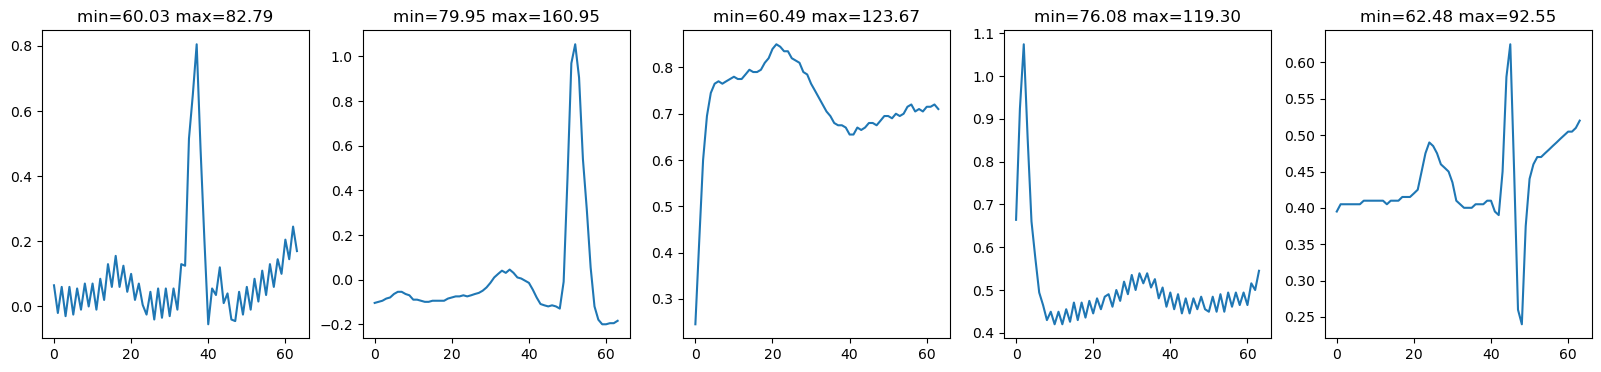

In [24]:
fig , axes = plt.subplots(1, 5 , figsize=(20,4))
axes = axes.flatten()
for i , j in enumerate(np.random.randint(0, 3e6,5)):
    ecg_plot = res.iloc[j, 0]
    bp_min_val = res.iloc[j,1]
    bp_max_val = res.iloc[j, 2]
    axes[i].plot(np.array(ecg_plot))
    axes[i].set_title(f"min={bp_min_val:0.2f} max={bp_max_val:0.2f}")
plt.savefig("E:/dataset/UCI_PPG/sample_test.png", pad_inches=0,bbox_inches="tight")

In [25]:
res.describe(include=['number']).round().astype(int)

,blood_presure_min,blood_presure_max
count,5208426,5208426
mean,68,125
std,12,24
min,50,54
25%,59,108
50%,65,124
75%,74,142
max,195,200


In [14]:
# 최소 혈압(DBP, 이완기 혈압) 조건 설정 (DBP 55 이상 120 이하)
# 최대 혈압(SBP, 수축기 혈압) 조건 설정 (SBP 90 이상 200 미만)
# 이완기 혈압(DBP)이 550이고, 수축기 혈압(SBP)이 200 미만인 데이터 개수를 반환

In [26]:
min_blood_mask = res['blood_presure_min'].between(55, 120, inclusive="both")
max_blood_mask = res['blood_presure_max'].between(90, 200, inclusive='left')
mask = np.logical_and(min_blood_mask , max_blood_mask)
mask.sum()

4455320

In [27]:
res = res[mask]
res.describe(include='number').round().astype(int)

,blood_presure_min,blood_presure_max
count,4455320,4455320
mean,69,130
std,11,22
min,55,90
25%,61,113
50%,67,127
75%,75,144
max,120,200


In [28]:
res.shape

(4455320, 3)

In [29]:
bp_max_set = np.array(res['blood_presure_max']).reshape(-1,1)
bp_max_set.shape

(4455320, 1)

In [30]:
bp_min_set = np.array(res['blood_presure_min']).reshape(-1,1)
bp_min_set.shape

(4455320, 1)

blood_presure_min | blood_presure_max | data (ECG 신호)
-------------------------------------------------------
       80         |       120         | [0.1, -0.5, ...]
       75         |       115         | [0.3, -0.2, ...]
      110         |       150         | [-0.1, 0.6, ...]

In [31]:
#get data 
ecgset = np.array(res['data'].to_list())
ecgset.shape

(4455320, 64)

In [32]:
def conv_block(x , num_filters):
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [37]:
def res_block(x , filters, shortcut_filter):
    y = x 
    for i in filters:
        x = conv_block(x, i)
    x = tf.keras.layers.Dropout(0.4)(x)
    y = tf.keras.layers.Conv1D(shortcut_filter,kernel_size=1 ,padding='same')(y)
    y = tf.keras.layers.ReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    res = tf.keras.layers.Add()([x, y])
    return res

In [38]:
def sequence_unit(x ,n_units):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units , activation="tanh",return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [84]:
def build_model():
    input_ = tf.keras.layers.Input(shape=(sample_size,1))
    y = sequence_unit(input_ , 64)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = sequence_unit(y , 256)
    y = tf.keras.layers.Conv1D(256 ,kernel_size=1 , padding='same', activation="relu")(y)
    x = tf.keras.layers.Conv1D(filters=16 , kernel_size=3 , padding='same')(input_)
    x = res_block(x, [16, 16 , 32], 32)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [32, 64, 64] , 64)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [64 , 128, 128] , 128)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [128,256,256] , 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [256,256,256] , 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Concatenate()([x,y])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out1 = tf.keras.layers.Dense(1 , activation="relu",name ="min")(x)
    out2 = tf.keras.layers.Dense(1 , activation="relu",name ="max")(x)
    model = tf.keras.models.Model(inputs=[input_], outputs={"min":out1 , "max":out2})
    return model

In [85]:
class HyperLoss(tf.keras.losses.Loss):
    def __init__(self , threshold=4,**kwargs):
        self.threshold = threshold
        super(HyperLoss ,self).__init__(**kwargs)
    def call(self, y_true ,  y_pred):
        error = y_true - y_pred
        is_samll = tf.abs(error)<self.threshold
        square_loss = tf.square(error)/2.0
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2.0
        return tf.where(is_samll , square_loss , linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}

In [86]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3) ,
                 loss=HyperLoss() , metrics=["mae"])

In [87]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 64, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_77 (Conv1D)            │ (None, 64, 16)            │              64 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_78 (Conv1D)            │ (None, 64, 16)            │             784 │ conv1d_77[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_70 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_78[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_79 (Conv1D)            │ (None, 64, 16)            │             784 │ re_lu_70[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_71 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_79[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_48        │ (None, 64, 16)            │              64 │ re_lu_71[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_80 (Conv1D)            │ (None, 64, 16)            │             784 │ batch_normalization_48[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_72 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_80[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_81 (Conv1D)            │ (None, 64, 16)            │             784 │ re_lu_72[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_73 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_81[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_49        │ (None, 64, 16)            │              64 │ re_lu_73[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_82 (Conv1D)            │ (None, 64, 32)            │           1,568 │ batch_normalization_49[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_74 (ReLU)               │ (None, 64, 32)            │               0 │ conv1d_82[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_83 (Conv1D)            │ (None, 64, 32)            │           3,104 │ re_lu_74[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_84 (Conv1D)            │ (None, 64, 32)            │             544 │ conv1d_77[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,365,730 (12.84 MB)

 Trainable params: 3,359,074 (12.81 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [88]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [99]:
def build_simple_model():
    input_ = tf.keras.layers.Input(shape=(64, 1))
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out1 = tf.keras.layers.Dense(1, activation="relu", name="min")(x)
    out2 = tf.keras.layers.Dense(1, activation="relu", name="max")(x)
    model = tf.keras.models.Model(inputs=[input_], outputs={"min": out1, "max": out2})
    return model

# HyperLoss 정의 (사용자의 환경에 맞게 수정 필요)
def hyper_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE 기반 손실 예시
    return loss

# 모델 생성
model2 = build_simple_model()

In [100]:
# 손실 함수와 옵티마이저 설정
losses = {
    "min": hyper_loss,
    "max": hyper_loss
}

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss=losses)

In [101]:
# 훈련/검증 데이터 분할
X_train, X_test, y_train_min, y_test_min, y_train_max, y_test_max = train_test_split(
    X, y_min, y_max, test_size=0.2, random_state=42
)

In [102]:
X_train.shape, y_train_min.shape, y_train_max.shape, X_test.shape, y_test_min.shape, y_test_max.shape, 

((3564256, 64, 1),
 (3564256, 1),
 (3564256, 1),
 (891064, 64, 1),
 (891064, 1),
 (891064, 1))

In [ ]:
# 모델 훈련
history = model2.fit(
    X_train,
    {"min": y_train_min, "max": y_train_max},  # 다중 출력 처리
    validation_split = 0.1,
    epochs=30,
    batch_size=32
)

Epoch 1/30


C:\ProgramData\anaconda33\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_508']
Received: inputs=Tensor(shape=(None, 64, 1))
  warnings.warn(msg)


 14679/100245 ━━━━━━━━━━━━━━━━━━━━ 22:54 16ms/step - loss: 787.8169 - max_loss: 621.6179 - min_loss: 166.1991

In [89]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드 (ECG 신호 및 혈압 레이블)
X = ecgset_prep  # (4455320, 64, 1)
y_min = bp_min_set  # (4455320, 1)
y_max = bp_max_set  # (4455320, 1)

In [90]:
# 훈련/검증 데이터 분할
X_train, X_test, y_train_min, y_test_min, y_train_max, y_test_max = train_test_split(
    X, y_min, y_max, test_size=0.2, random_state=42
)

In [93]:
X_train.shape, y_train_min.shape, y_train_max.shape, X_test.shape, y_test_min.shape, y_test_max.shape, 

((3564256, 64, 1),
 (3564256, 1),
 (3564256, 1),
 (891064, 64, 1),
 (891064, 1),
 (891064, 1))

In [94]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=HyperLoss(),  # 사용자 정의 손실 함수 적용
    metrics={"min": "mae", "max": "mae"}  # 개별 출력에 대해 MAE 사용
)


In [95]:
# 모델 훈련
history = model.fit(
    X_train,
    {"min": y_train_min, "max": y_train_max},  # 다중 출력 처리
    validation_split = 0.1,
    epochs=30,
    batch_size=32
)

Epoch 1/30


C:\ProgramData\anaconda33\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_377']
Received: inputs=Tensor(shape=(None, 64, 1))
  warnings.warn(msg)


   102/100245 ━━━━━━━━━━━━━━━━━━━━ 14:11:06 510ms/step - loss: 224.5795 - max_loss: 148.2565 - max_mae: 38.9994 - min_loss: 76.3229 - min_mae: 20.9652

KeyboardInterrupt: 